# [Wilson-Cowan SDE model in Cupy](https://github.com/Ziaeemehr/vbi_paper/blob/main/docs/examples/wilson_cowan_cupy.ipynb)


<a href="https://colab.research.google.com/github/Ziaeemehr/vbi_paper/blob/main/docs/examples/wilson_cowan_cupy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import os
import vbi
import torch
import numpy as np
import networkx as nx
from copy import deepcopy
import sbi.utils as utils
from scipy.signal import welch
import matplotlib.pyplot as plt
from sbi.analysis import pairplot
from vbi.sbi_inference import Inference
from vbi.models.cupy.wilson_cowan import WC_sde

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed = 42
np.random.seed(seed)

In [3]:
LABESSIZE = 10
plt.rcParams['axes.labelsize'] = LABESSIZE
plt.rcParams['xtick.labelsize'] = LABESSIZE
plt.rcParams['ytick.labelsize'] = LABESSIZE

To change the frequency of oscillations in this model, there are several key parameters to adjust:

1. Coupling strengths
2. Time constants 
3. External inputs
4. Refractory periods 
5. Sigmoid function parameters

Sweeping over External current to Excitatory population (P)

In [4]:
ns = 30
P = np.zeros((2,ns))
values = np.linspace(0,3,ns)
P[0, :] = values
P[1, :] = values
weights = np.array([[0,1],[1,0]], dtype=np.float32)

par = {
    "g_e": 0.0,
    "seed": 42,
    "dt": 0.1,
    "t_end": 2000.0,
    "t_cut": 101.0,
    "noise_amp": 0.001,
    "decimate": 1,
    "P": P,
    "num_sim": ns,
    "RECORD_EI": "EI",
    "engine": "cpu",
    "weights": weights,
    "dtype": "float32",
    "same_initial_state": False,
}

In [ ]:
obj = WC_sde(par)
sol = obj.run()
t = sol["t"]
E = sol["E"]
I = sol["I"]
print(t.shape, E.shape, I.shape)

Sweeping over Bifurcation parameter P

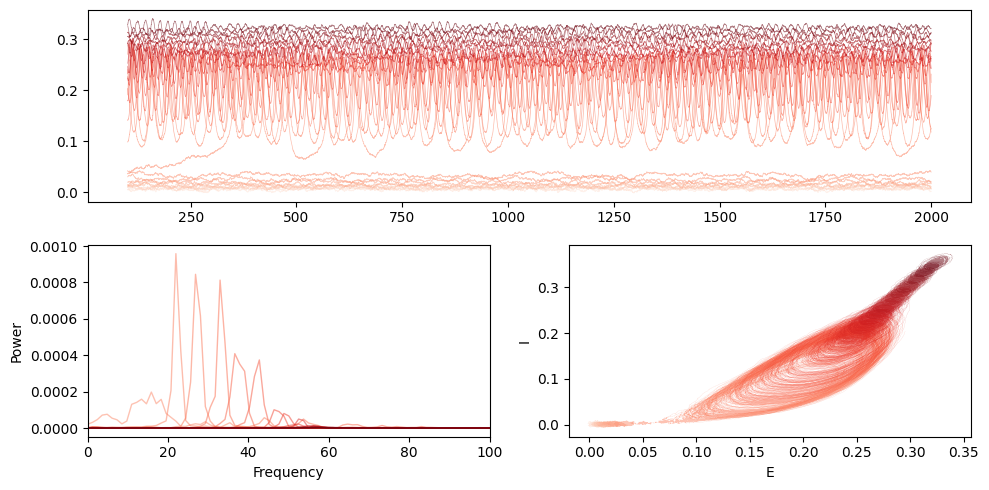

In [6]:
f, P_E = welch(E[:, 0, :], fs=1/(par["dt"]*par['decimate']) * 1000, nperseg=8*1024, axis=0)

mosaic = """
AA
BC
"""
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax = fig.subplot_mosaic(mosaic)

colors = plt.cm.Reds(np.linspace(0.1,1.0, ns))
for i in range(ns):
    ax['A'].plot(t, E[:, 0, i], alpha=0.5, lw=0.5, color=colors[i])

for i in range(ns):
    ax['B'].plot(f, P_E[:, i], alpha=0.5, lw=1, color=colors[i], label=f"{P[0,i]:.2f}")

for i in range(ns):
    ax['C'].plot(E[:,0,i], I[:,0, i], lw=0.1, alpha=0.5, color=colors[i])

ax['B'].set_xlabel("Frequency")
ax['B'].set_ylabel("Power")
ax['B'].set_xlim(0, 100)
ax['C'].set_xlabel("E")
ax['C'].set_ylabel("I")
# ax['B'].legend(ncol=2)
plt.tight_layout()

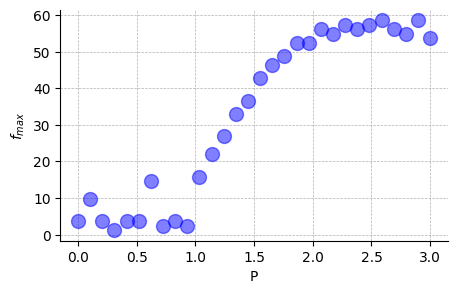

In [7]:
idx_max = np.argmax(P_E, axis=0)
fmax = f[idx_max]
fig, ax = plt.subplots(1, figsize=(5,3))
ax.plot(values, fmax, "bo", ms=10, alpha=0.5)
ax.grid(True, ls='--', lw=0.5)
ax.set_xlabel("P")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(r"$f_{max}$");

In [ ]:

weights = np.array([[0,1],[1,0]], dtype=np.float32)
P = 1.025

par = {
    "g_e": 0.0,
    "seed": 42,
    "dt": 0.05,
    "t_end": 2000.0,
    "t_cut": 101.0,
    "noise_amp": 0.0005, # add small amount of noise
    "decimate": 1,
    "P": P,
    "num_sim": 1,
    "RECORD_EI": "EI",
    "engine": "cpu",
    "weights": weights,
    "dtype": "float32",
    "same_initial_state": False,
}

obj = WC_sde(par)
sol = obj.run()
t = sol["t"]
E = sol["E"]
I = sol["I"]

f, P_E = welch(E[:, :, 0], fs=1/(par["dt"]*par['decimate']) * 1000, nperseg=5*1024, axis=0)
f, P_I = welch(I[:, :, 0], fs=1/(par["dt"]*par['decimate']) * 1000, nperseg=5*1024, axis=0)

mosaic = """
AA
BC
"""
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax = fig.subplot_mosaic(mosaic)

ax['A'].plot(t, E[:, 0, 0], label="E", color="red", alpha=1, lw=0.5)
ax['A'].plot(t, I[:, 0, 0], label="I", color="blue", alpha=1, lw=0.5)
ax['B'].plot(f, P_E[:, 0], label="E", color="red", alpha=1, lw=1)
ax['B'].plot(f, P_I[:, 0], label="I", color="blue", alpha=1, lw=1)
ax['B'].set_xlabel("Frequency")
ax["B"].set_ylabel("Power")
ax['B'].set_xlim(0, 100)
ax['C'].plot(E[:, 0, 0], I[:, 0, 0], lw=0.5)
ax['C'].set_xlabel("E")
ax['C'].set_ylabel("I");

f_max = f[np.argmax(P_E[:,0])]
ax['B'].legend([f"fmax={f_max:.2f}"])
plt.tight_layout()


### whole brain (connectome)

In [9]:
D = vbi.LoadSample(nn=88)
weights = D.get_weights()
nn = weights.shape[0]
print(f"number of nodes: {nn}")

number of nodes: 88


In [10]:
g_e = np.array([0.6])
par = {
    "g_e": g_e,
    "seed": 42,
    "dt": 0.1,
    "t_end": 1000.0,
    "t_cut": 101.0,
    "noise_amp": 0.002,
    "decimate": 1,
    "P": 1.,
    "num_sim": len(g_e),
    "RECORD_EI": "EI",
    "engine": "cpu",
    "weights": weights,
    "dtype": "float32",
    "same_initial_state": False,
}


In [ ]:
obj = WC_sde(par)
sol = obj.run()
# print(obj)

(8989,) (8989, 88, 1) (8989, 88, 1)


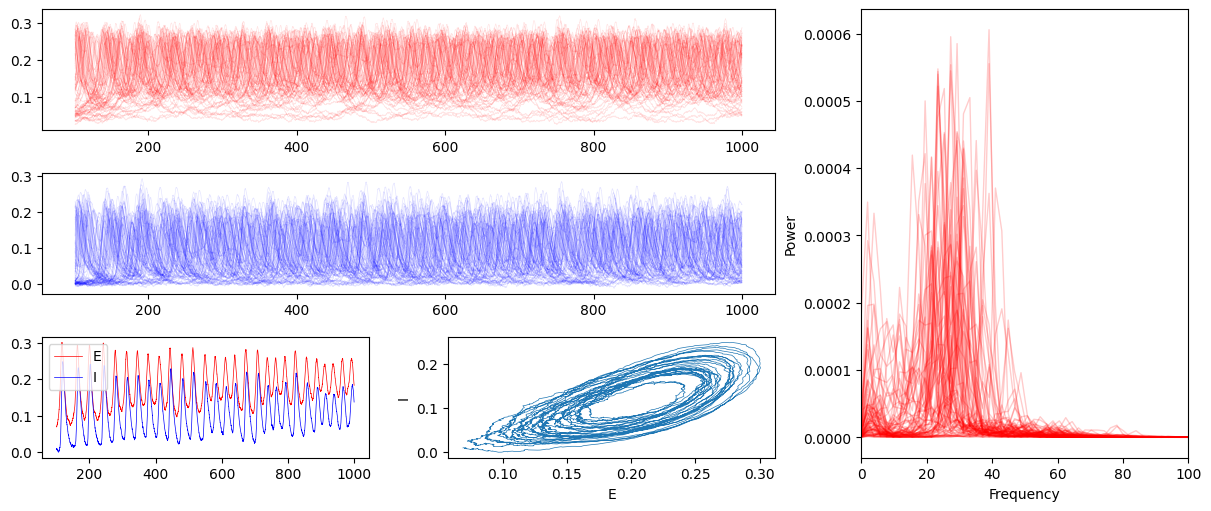

In [12]:
t = sol["t"]
E = sol["E"]
I = sol["I"]
print(t.shape, E.shape, I.shape)

f, P_E = welch(E[:, :, 0], fs=1/(par["dt"]*par['decimate']) * 1000, nperseg=5*1024, axis=0)
f, P_I = welch(I[:, :, 0], fs=1/(par["dt"]*par['decimate']) * 1000, nperseg=5*1024, axis=0)


mosaic = """
AAB
CCB
DEB
"""
fig = plt.figure(constrained_layout=True, figsize=(12, 5))
ax_dict = fig.subplot_mosaic(mosaic)
ax = [ax_dict[key] for key in ax_dict]

ax[0].plot(t, E[:, :, 0], label="E", color="red", alpha=0.1, lw=0.5)
ax[2].plot(t, I[:, :, 0], label="I", color="blue", alpha=0.1, lw=0.5)
ax[3].plot(t, E[:, 0, 0], label="E", color="red", lw=0.5)
ax[3].plot(t, I[:, 0, 0], label="I", color="blue", lw=0.5)
ax[3].legend()
ax[4].plot(E[:, 0, 0], I[:, 0, 0], lw=0.5)
ax[4].set_xlabel("E")
ax[4].set_ylabel("I")

# plot power spectrum of E and I at ax[1]
ax[1].plot(f, P_E, label="E", alpha=0.2, lw=1, color="red")
# ax[1].plot(f, P_I, label="I", color="blue", alpha=0.1, lw=1)
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel("Power")
ax[1].set_xlim(0, 100)

plt.show()